# Figure 3. Comparison of in vitro and in vivo cleavage patterns
A. Comparison of productively processed miRNAs *in vitro* and *in vivo*  
B. Comparison of cleavage sites *in vitro* and *in vivo*  
C. Comparison of cleavage specificity *in vitro* and *in vivo*  

In [1]:
import time
today = time.strftime('%Y-%m-%d')
name = 'Seungchan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by Seungchan Baek at 2020-10-13.


In [2]:
home = '/casa/bsc/projects/1_DCS/2004_paper_prep/'
%cd $home

/casa/bsc/projects/1_DCS/2004_paper_prep


In [3]:
from __future__ import division
import sys; sys.path.append('/casa/bsc/notebooks/')
from util import *
from basic import gen_result_dir
resultpath = gen_result_dir('results/')
print 'resultpath:', resultpath

resultpath: results/201013/


In [4]:
import pandas as pd
import numpy as np
import re
import gzip
from matplotlib import pyplot as plt
from matplotlib import gridspec, lines
%matplotlib inline

In [5]:
LIBRARIES = [ 'set1', 'set2', 'set3', 'set4', 'set5' ]

#### Import supplementary tables

In [6]:
s1 = pd.read_csv('supplementary/201012_s1_pri-info.csv', header=1, index_col=0)
s2 = pd.read_csv('supplementary/201012_s2_pri-construct.csv', header=1, index_col=0)
s5 = pd.read_csv('supplementary/201012_s5_pri-structure.csv', header=1, index_col=0)
s6 = pd.read_csv('supplementary/201012_s6_cleavage-patterns.csv', header=1, index_col=0)
s7 = pd.read_csv('supplementary/201012_s7_cleavage-sites.csv', header=1, index_col=0)
print 's1:\t%s'%', '.join(list(s1.columns))
print 's2:\t%s'%', '.join(list(s2.columns)[:6])
print 's5:\t%s'%', '.join(list(s5.columns)[-10:])
print 's6:\t%s'%', '.join(list(s6.columns)[-4:])
print 's7:\t%s'%', '.join(list(s7.columns)[:7])

s1:	5p mature, 5p sequence, 3p mature, 3p sequence, Note
s2:	Chr, Start, End, Strand, Construct sequence, 100way phyloP scores (pre-miRNA -/+ 100nt)
s5:	117, 118, 119, 120, 121, 122, 123, 124, 125, symbolized structure
s6:	Relative position from miRBase site, Cleavage Specificity, Cleavage Imbalance, Cleavage type
s7:	Chr, miRBase 5' site, miRBase 3' site, IVP 5' site, IVP 3' site, fCLIP 5' site, fCLIP 3' site


In [7]:
def get_pre_position(pri):
    constructseq = s2.loc[pri, 'Construct sequence'].replace('T','U')
    seq5p = s1.loc[pri, '5p sequence']
    seq3p = s1.loc[pri, '3p sequence']
    if seq5p=='n.a.' or constructseq.find(seq5p)==-1:
        prestart = 0
    else:
        prestart = constructseq.find(seq5p)+1
    if seq3p=='n.a.' or constructseq.find(seq3p)==-1:
        preend = 0
    else:
        preend = constructseq.rfind(seq3p)+len(seq3p)
    return prestart, preend

In [8]:
allpris = s1.index
preposition = { pri:get_pre_position(pri) for pri in allpris }
print len(preposition)

1881


In [9]:
mirtrons = [ pri for pri in allpris if s1.loc[pri,'Note'].find('Mirtron')>=0 ]
capped = [ pri for pri in allpris if s1.loc[pri,'Note'].find('Capped miRNA')>=0 ]
drosensitive = [ pri for pri in allpris if s1.loc[pri,'Note'].find('DROSHA KO-sensitive')>=0 ]
fclipdetected = [ pri for pri in allpris if s1.loc[pri,'Note'].find('fCLIP site-determined')>=0 ]
dbmirs = [ pri for pri in allpris if s1.loc[pri,'Note'].find('MirGeneDB')>=0 ]
print len(mirtrons), len(capped), len(drosensitive), len(fclipdetected), len(dbmirs)

239 11 157 281 519


In [10]:
priseqs = dict(s2['Construct sequence'])
print len(priseqs)

1881


# A. Comparison of productively processed miRNAs in vitro and in vivo

In [11]:
pros = s6['Cleavage Productivity'].to_dict()
s6sort = s6.sort_values('Cleavage Specificity')
spes = s6sort[~s6sort.index.duplicated(keep='last')]['Cleavage Specificity'].to_dict()
overlap = [ mir for mir in pros if mir in spes ]
print len(overlap)

1816


In [12]:
single = set(s6[s6['Cleavage type']=='single'].index)
multi = set(s6[s6['Cleavage type']=='multiple'].index)
inverted = set(s6[s6['Cleavage type']=='inverted'].index)
nick5 = set(s6[s6['Cleavage type']=='nick5'].index)
nick3 = set(s6[s6['Cleavage type']=='nick3'].index)
nick = list(nick5) + list(nick3)
nonspec = set(s6[s6['Cleavage type']=='non-specific'].index)
dcsmirs = list(single) + list(multi)
nodcs = list(inverted) + list(nick) + list(nonspec)
print 'Productive: %s, Unproductive: %s' % (len(dcsmirs), len(nodcs))
print 'Single: %s, Multiple: %s, Inverted: %s, Nick: %s, Non-specific: %s'\
% (len(single), len(multi), len(inverted), len(nick), len(nonspec))
print "5' nick: %s, 3' nick: %s" % (len(nick5), len(nick3))

Productive: 512, Unproductive: 1304
Single: 445, Multiple: 67, Inverted: 156, Nick: 107, Non-specific: 1041
5' nick: 72, 3' nick: 35


In [13]:
prod = [ mir for mir in fclipdetected if mir in dcsmirs ]
unpr = [ mir for mir in fclipdetected if mir in nodcs ]
data = [ len(prod), len(unpr) ]
colors = [ '#1b9e77', '#bababa' ]
labels = ['Unproductive/ No processing', 'Productive processing']

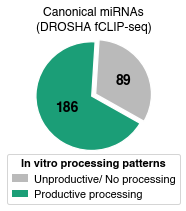

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ps, ts = ax.pie(data, colors=colors, explode=[.04]*len(data), startangle=-30, counterclock=False)
for p in ps:
    p.set_linewidth(1.3)
    p.set_edgecolor('white')
ax.text(-.7,-.3, data[0], fontsize=14, weight='bold')
ax.text(.4,.2, data[1], fontsize=14, weight='bold')
ax.text(0, 1.2, 'Canonical miRNAs\n(DROSHA fCLIP-seq)', ha='center', fontsize=12)
leg = ax.legend(ps[::-1], labels, loc=(-.12,-.3), prop={'size':11}, 
          handlelength=1.5, handletextpad=.5, title='In vitro processing patterns')
leg.get_title().set_fontsize(11); leg.get_title().set_weight('bold')
leg.get_patches()[0].set_linewidth(0); leg.get_patches()[1].set_linewidth(0)
#fig.savefig(resultpath + '200728_f3a_intersection.pdf')

# B. Comparison of cleavage sites in vitro and in vivo

In [15]:
t1 = s7[s7['Type']=='I'].index
t2 = s7[s7['Type']=='II'].index
t3 = s7[s7['Type']=='III'].index
t4 = s7[s7['Type']=='IV'].index
print len(t1), len(t2), len(t3), len(t4)

149 15 8 14


In [16]:
sitescomp = {}
for mir, row in s7[s7.fillna('')['Type']!=''].iterrows():
    mb5, ivp5, fcl5, strand = row[["miRBase 5' site","IVP 5' site","fCLIP 5' site",'Strand']]
    if strand=='+':
        ivp5 = [ int(i)-int(mb5) for i in ivp5.split(', ') ]
        fcl5 = [ int(f)-int(mb5) for f in fcl5.split(', ') ]
    if strand=='-':
        ivp5 = [ int(mb5)-int(i) for i in ivp5.split(', ') ]
        fcl5 = [ int(mb5)-int(f) for f in fcl5.split(', ') ]
    
    both = list(set(ivp5)&set(fcl5))
    fonly = list(set(fcl5)-set(ivp5))
    ionly = list(set(ivp5)-set(fcl5))
    sitescomp[mir] = (both, fonly, ionly)

In [17]:
t1 = sorted(t1, key=lambda x: (abs(sitescomp[x][0][0]),len(sitescomp[x][0])))
t2 = sorted(t2, key=lambda x: (abs(sitescomp[x][0][0]),len(sitescomp[x][0])))
t3 = sorted(t3, key=lambda x: (abs(sitescomp[x][0][0]), len(sitescomp[x][1])))
t4 = sorted(t4, key=lambda x: (len(sitescomp[x][1]), abs(sitescomp[x][1][0])))
print len(t1), len(t2), len(t3), len(t4)

149 15 8 14


In [18]:
colorf, colori, colorboth = '#1b9e77', '#e7298a', '#885772'

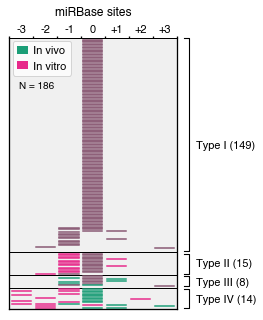

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(3,5))
i, nums = 1, []
ax.axhline(0, ls='-', lw=1, color='k')
for mirl in [ t1, t2, t3, t4 ]:
    for mir in mirl:
        both, fonly, ionly = sitescomp[mir]
        for s in both:
            ax.plot([s-.4,s+.4], [i,i], color=colorboth, lw=1.5)
        for s in fonly:
            ax.plot([s-.4,s+.4], [i,i], color=colorf, lw=1.5)
        for s in ionly:
            ax.plot([s-.4,s+.4], [i,i], color=colori, lw=1.5)
        i+=1
    ax.axhline(i, ls='-', lw=1, color='k')
    nums.append(i)
    i+=1
i-=1
ax.bar([-5], [0], color=colorf, label='In vivo')
ax.bar([-5], [0], color=colori, label='In vitro')
ax.legend(handletextpad=.5, loc=(.02, .86), prop={'size':11}, handlelength=1)

# format
ax.set_xlim(-3.5, 3.5)
ax.set_ylim(-.5, i)
ax.text(-3.1, 35, 'N = 186')
ax.invert_yaxis()
ax.spines['right'].set_visible(True)
ax.spines['right'].set_bounds(0, i); ax.spines['left'].set_bounds(0, i)
ax.set_facecolor('#f0f0f0')
ax.set_xticks(range(-3, 4))
ax.set_xticks(np.arange(-3.5, 4, 1), minor=True)
ax.set_xticklabels(['-3','-2','-1','0','+1','+2','+3'])
ax.tick_params(which='major', axis='x', length=0)
ax.tick_params(which='minor', axis='x', width=1.3)
ax.xaxis.set_ticks_position('top')
ax.set_yticks([])
ax.text(0, -16, 'miRBase sites', ha='center', fontsize=12)
ys = [75,158,171,183]
for (num1,num2),t,lab,y in zip(zip([-1]+nums[:3],nums),[t1,t2,t3,t4],['I','II','III','IV'],ys):
    l = lines.Line2D([3.8,4,4,3.8], [num1+1,num1+1,num2-1,num2-1], linewidth=1.1, color='black')
    l.set_clip_on(False); ax.add_line(l)
    ax.text(4.3, y, 'Type %s (%s)'%(lab,len(t)), fontsize=11, va='center')
#fig.savefig(resultpath + '200728_f3b_cs-comparison.pdf')

# C. Comparison of cleavage specificity in vitro and in vivo

In [20]:
sub = s7[['IVP PCS','fCLIP PCS']].dropna()
fspes = sub['fCLIP PCS'].to_dict()
ispes = sub['IVP PCS'].to_dict()
mirs = sub.index
print len(mirs)

243


In [21]:
xs = [ fspes[mir] for mir in mirs ]
ys = [ ispes[mir] for mir in mirs ]
xs2 = [ fspes[mir] for mir in ['hsa-mir-142','hsa-mir-17'] ]
ys2 = [ ispes[mir] for mir in ['hsa-mir-142','hsa-mir-17'] ]
xsmt = [ fspes[mir] for mir in mirs if mir in mirtrons]
ysmt = [ ispes[mir] for mir in mirs if mir in mirtrons ]
s = 15
lw = .7
fcolor, ecolor = '#bababa', '#545454'
fcolor2, ecolor2 = [ '#de2d26','tab:blue' ], [ '#a50f15', '#08519c' ]
fcolormt, ecolormt = [ '#323232', 'black' ]

Text(0.45,0.9,u'mir-142')

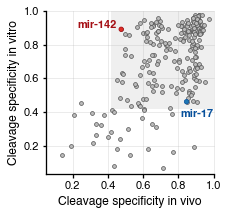

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(xs, ys, s=s, lw=lw, edgecolor=ecolor, facecolor=fcolor, zorder=2)
ax.scatter(xs2, ys2, s=s+5, lw=lw, edgecolors=ecolor2, facecolors=fcolor2, zorder=2)
#ax.scatter(xsmt, ysmt, s=s+5, lw=lw, edgecolor=ecolormt, facecolor=fcolormt, zorder=2)

ax.set_xlim(.05, 1)
ax.set_ylim(.03, 1)
ax.set_xlabel('Cleavage specificity in vivo', fontsize=12)
ax.set_ylabel('Cleavage specificity in vitro', fontsize=12)
ax.spines['left'].set_bounds(.03,1)
ax.spines['bottom'].set_bounds(.05,1)

squ = plt.Rectangle((-.01,-.01), 1.02, 1.01, fc='w'); ax.add_patch(squ)
ax.grid(clip_path=squ, ls='-', lw=.5)
squ = plt.Rectangle((-.01,-.01), 1.02, 1.01, fc='w'); ax.add_patch(squ)
ax.grid(clip_path=squ)
sq1 = plt.Rectangle((.42,.42), .58, .58, fc='#cdcdcd', alpha=.3); ax.add_patch(sq1)

#ax.text(.18, .12, 'Mirtrons', fontsize=11, weight='bold')
ax.text(.81, .37, 'mir-17', fontsize=11, weight='bold', color='#08519c')
ax.text(.45, .9, 'mir-142', fontsize=11, weight='bold', color='#a50f15', ha='right')
#fig.savefig(resultpath + '201008_f3c_specificity_comparison.pdf')